#### Based on 
https://github.com/avisoori-databricks/Tuning-the-Finetuning
https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms

In [ ]:
%pip install transformers==4.31.0 datasets==2.13.0 peft==0.4.0 accelerate==0.21.0 bitsandbytes==0.40.2 trl==0.4.7

In [ ]:
dbutils.library.restartPython()

In [ ]:
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch
from transformers.trainer_callback import TrainerCallback
import os
from transformers import BitsAndBytesConfig
from trl import SFTTrainer
import mlflow

In [ ]:
%sql
USE description_generator;

In [ ]:
df = spark.sql("SELECT * FROM product_name_to_description").toPandas()
df['text'] = df["prompt"]+df["response"]
df.drop(columns=['prompt', 'response'], inplace=True)
display(df), df.shape

text Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: Fujinon Lens XF80mm
F2.8 R LM OIS WR Macro, belonging to category: Camera Lens

### Response:
As the first XF lens with a 1:1 image scale, this macro lens is perfectly tailored to taking close-up shots. Its enhanced optical design reduces chromatic and spherical aberrations and offers a high resolution. Focusing the motif has been optimised through the utilisation of two precise focus groups and a linear motor. Together with the rich bokeh, it guarantees successful nature photographs. The intuitively operated lens is protected against water, dust and cold.
### End Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: Logitech Scribe, belonging to category: Whiteboard Camera for Video Conferencing Rooms

### Response:
This camera can be mounted on whiteboards and other surfaces to incorporate analogue text and images into digital meetings. Thanks to a special lens, AI technology and image enhancement, the Scribe enables participants who are not physically present to have a good view of the content. The handy helper can be easily attached to all dry surfaces and, thanks to the wireless share button, allows simple and intuitive sharing of content at the touch of a button.
### End Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: Resysta® Universal Performance Board, belonging to category: Foamed Board

### Response:
The Universal Performance Board is made of Resysta fibre-reinforced composite material and comes with numerous user-friendly qualities. It is water-resistant and can be processed easily, just like natural wood. It withstands screw removal, is suitable for nails, can be glued and is thermoformable. The boards can be used both indoors and outside. They have the look and feel of natural wood and can be customised with special colours to suit individual colour preferences. The Universal Performance Board is available in different thicknesses and can also be manufactured to specific dimensions upon request.
### End Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: SoundPlate™ LAP340, belonging to category: Speaker System

### Response:
SoundPlate is a 4.1-channel speaker system that can simultaneously serve as a television pedestal. The design is characterised by narrow lines that foster a minimalist appearance, contrasting with the convincing sound volume of the device. The modular speaker design delivers sound effectively and without sound transfer. Thanks to its reserved design, SoundPlate blends with nearly every TV screen.
### End Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: Keshif Istanbul, belonging to category: City Game

### Response:
This city game, of sleek and sensuous design, invites players to explore Istanbul, the fascinating megalopolis on the Bosphorus. In the form of a “memüri” game, it offers a kaleidoscopic view of the city in 81 picture facets and texts. Arranged altogether, the 81 distinctively shaped cards, with a simple line drawing of a cupola, create a rhombic ornament. The reverse side of the cards shows a detail of one of the city’s unexpected sights together with a symbol representing a category. Two images from the same subject make up one pair of cards.
### End Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a de

(None, (5000, 1))

In [ ]:
from datasets import load_dataset
from datasets import Dataset
dataset = Dataset.from_pandas(df).train_test_split(test_size=0.05, seed=42)

In [ ]:
# target_modules = ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head']
#or
target_modules = ['q_proj','v_proj']

lora_config = LoraConfig(
    r=8,#or r=16
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    target_modules = target_modules,
    task_type="CAUSAL_LM",
)

base_dir = "/dbfs/finetuning"

per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = 'adamw_hf'
learning_rate = 1e-5
max_grad_norm = 0.3
warmup_ratio = 0.03
lr_scheduler_type = "linear"


from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir=base_dir,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs = 3.0,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [ ]:
model_path = 'openlm-research/open_llama_3b_v2'

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


1

In [ ]:
model = LlamaForCausalLM.from_pretrained(
    model_path, device_map='auto', load_in_8bit=True,
)

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,662,400 || all params: 3,429,136,000 || trainable%: 0.07764054852300988


In [ ]:
trainer = SFTTrainer(
    model,
    train_dataset=dataset['train'],
    eval_dataset = dataset['test'],
    dataset_text_field="text",
    max_seq_length=256,
    args=training_args,
)
#Upcast layer norms to float 32 for stability
for name, module in trainer.model.named_modules():
  if "norm" in name:
    module = module.to(torch.float32)

Using pad_token, but it is not set yet.


Map:   0%|          | 0/4750 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
with mlflow.start_run(run_name='Lora_finetune'):
  trainer.train()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
[W reducer.cpp:1300] Warning: find_unused_parame

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


#### Some metrics from MLFlow

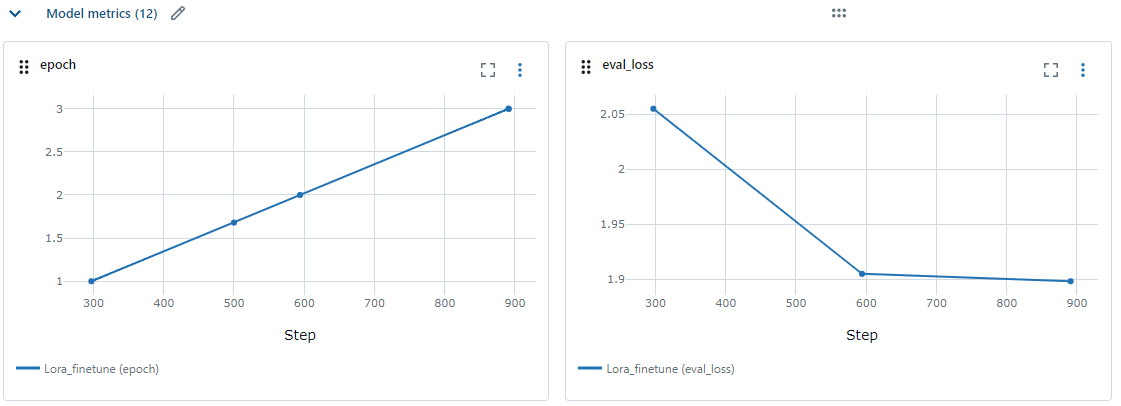

#### Checpoint folder on S3 (dbfs)
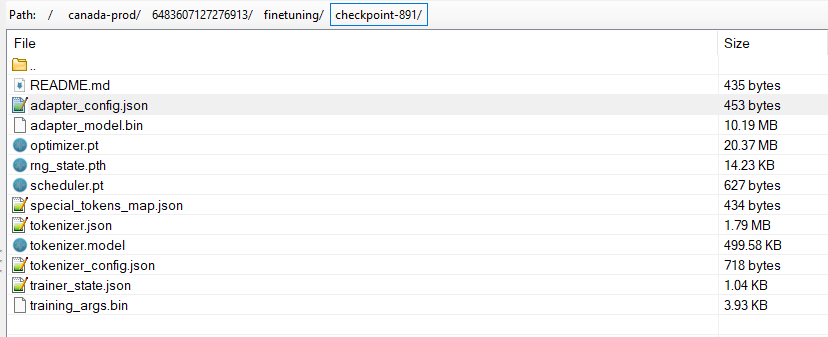
